##Importing Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.ticker import MaxNLocator
from tensorflow import keras
from keras import backend as K
from keras import layers, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import cv2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
#Training on GPU if it is available
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')
    

Training on GPU!


####batch size and number of classes

In [ ]:
batch_size = 32
num_classes = 2

##Data Loading

In [ ]:
from numpy.core.numerictypes import ScalarType
class Train_CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/"
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.*"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"COVID" : 0, "NORMAL": 1}
        self.img_dim = (28, 28)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)/255
        img_tensor = torch.unsqueeze(img_tensor, dim=-1)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

In [ ]:
class Test_CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "/content/drive/MyDrive/COVID_CT_DATASET2/TEST/"
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.*"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"COVID" : 0, "NORMAL": 1}
        self.img_dim = (28, 28)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)/255
        img_tensor = torch.unsqueeze(img_tensor, dim=-1)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id.squeeze()

In [ ]:
train_dataset = Train_CustomDataset()
test_dataset = Test_CustomDataset()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL', '/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/COVID']
[['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (1).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (10).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (100).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (101).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (102).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (103).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (104).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (105).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (106).png', 'NORMAL'], ['/content/drive/MyDrive/COVID_CT_DATASET2/TRAIN/NORMAL/Non-Covid (107).png', 'NORMAL']

In [ ]:
print("number of training examples:",len(train_dataset.data))
print("number of test examples:",len(test_dataset.data))

number of training examples: 1737
number of test examples: 744


In [ ]:
class_names = ["COVID","NORMAL"]

###Dimensions of the image tensor and Target class labels

In [ ]:
for batch_i, (images, target) in enumerate(train_loader):
            print("batch:",batch_i)
            print("image tensor shape:",images.shape)
            print("target class labels: ",target)
            break

batch: 0
image tensor shape: torch.Size([32, 1, 28, 28])
target class labels:  tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1])


###Plotting the input images

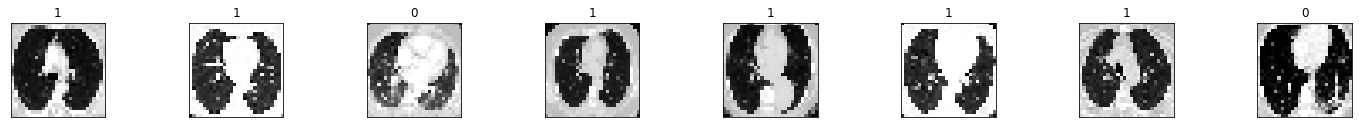

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(8):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title(str(labels[idx].item()))

#CAPSULE NETWORK

##Capsule Levels

In [ ]:
class CapsuleLevel(nn.Module):
    def __init__(self, in_channels, out_channels, capsule_dimension = 8, num_capsules = 2, num_capsule_units = 6 * 6 * 32, routing = False, iterations=3):
        super(CapsuleLevel, self).__init__()
        self.routing = routing
        self.iterations = iterations
        self.num_capsules = num_capsules
        self.num_capsule_units = num_capsule_units
        if routing == True:
            self.route_weights = nn.Parameter(torch.randn(num_capsule_units, num_capsules, out_channels, in_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=(9, 9), stride=(2, 2), padding=0) for _ in
                 range(capsule_dimension)])

            
    # The squash function
    def squash(self, s, dim=-1):
        norm = torch.sum(s**2, dim=dim, keepdim=True)
        return norm / (1 + norm) * s / (torch.sqrt(norm) + 1e-8)

    def forward(self, x):
        if self.routing == True:          
            batch_size = x.size(0)
            
            route_weights = torch.stack([self.route_weights] * batch_size, dim = 0) #dim:([1152, 10, 16, 8])
            x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4) #dim:([128, 1152, 10, 8, 1])
            u_hat = torch.matmul(self.route_weights, x)  #dim:([128, 1152, 10, 16, 1])
            u_hat = u_hat.squeeze(-1)   #dim([128, 1152, 10, 16])
            temp_u_hat = u_hat.detach()
            
            #b_ij dim:([128, 1152, 10, 1])
            b_ij = Variable(torch.zeros(batch_size, self.num_capsule_units, self.num_capsules, 1).cuda()) 
            for iteration in range(self.iterations):
                c_ij = F.softmax(b_ij, dim=1)   # Equation 1 # c_ij dim:([128, 1152, 10, 1])
                s_ij = (c_ij * temp_u_hat).sum(dim=1)  # Equation 2 # s_ij dim:([128, 10, 16])
                temp_u_hat = temp_u_hat.unsqueeze(3)  # temp_u_hat dim:([128, 1152, 10, 16, 1])
                v_j = self.squash(s_ij, dim=2) # Equation 3  # v_j dim:([128, 10, 16])
                v_j_i = torch.stack([v_j] * self.num_capsule_units, dim = 1).unsqueeze(-1) # v_j_i dim:([128, 10, 16, 1])
                v_j_i = torch.matmul(temp_u_hat, v_j_i).squeeze(3)  
                temp_u_hat = temp_u_hat.squeeze(3)
                b_ij = b_ij + v_j_i # Equation 4
        else:
            v_j = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]   
            v_j = torch.cat(v_j, dim=-1)
            v_j = self.squash(v_j)

        return v_j

In [ ]:
class CapsuleNetwork(nn.Module):  
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.batch_size = 32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(9, 9), stride=(1, 1), padding=0)
        #self.conv1 = AugmentedConv(in_channels=256, out_channels=1, kernel_size=3, dk=40, dv=4, Nh=4, relative=True, stride=2, shape=14).to(device)
        self.primaryCaps = CapsuleLevel(in_channels=256, out_channels=32, capsule_dimension=8)
        self.digitCaps   = CapsuleLevel(in_channels=8, out_channels=16, num_capsules=2, routing=True)
        self.decoder     = nn.Sequential(
            nn.Linear(16 *2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        if y is None:
            # Get most active capsule
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(2)).cuda().index_select(dim=0, index=Variable(max_length_indices.data))
        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return classes, reconstructions

In [ ]:
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
        self.reconstruction_loss = nn.BCELoss(size_average=False)

    def forward(self, img, target, classes, reconstructions):
        fn_1 = F.relu(0.9 - classes, inplace=True) ** 2  # Calculation of loss for correct digit cap
        fn_2 = F.relu(classes - 0.1, inplace=True) ** 2  # Calculation for incorrect digit cap
        margin_loss = target * fn_1 + 0.5 * (1. - target) * fn_2
        margin_loss = margin_loss.sum()
        img = img.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, img)
        return (margin_loss + 0.0005 * reconstruction_loss) / img.size(0)

In [ ]:
train_loss = []
test_loss = []
def train(train_loader, epoch):
    global model
    model.train()
    if torch.cuda.is_available():
        model = model.cuda()
    tr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size(0)
        labels = target
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        capsule_loss = LossFunction()
        labels = torch.LongTensor(labels)
        labels = torch.eye(2).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        optimizer.zero_grad()
        classes, reconstructions = model(data, labels)
        loss = capsule_loss(data, labels, classes, reconstructions)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        pred = classes.data.max(1, keepdim=True)[1]
        if (batch_idx + 1)% 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

In [ ]:
def evaluate(data_loader):
    global model
    model.eval()
    loss = 0
    
    for data, target in data_loader:
        labels = target
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        labels = torch.LongTensor(labels)
        labels = torch.eye(2).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        classes, reconstructions = model(data)
        capsule_loss = LossFunction()
        loss += capsule_loss(data, labels, classes, reconstructions).item()
        pred = classes.data.max(1, keepdim=True)[1]
    loss /= len(data_loader.dataset)
    test_loss.append(loss)
    print('\nAverage Validation loss: {:.6f}\n'.format(loss))

##Model Architecture

In [ ]:
summary(CapsuleNetwork().cuda(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 20, 20]          20,992
            Conv2d-2             [-1, 32, 6, 6]         663,584
            Conv2d-3             [-1, 32, 6, 6]         663,584
            Conv2d-4             [-1, 32, 6, 6]         663,584
            Conv2d-5             [-1, 32, 6, 6]         663,584
            Conv2d-6             [-1, 32, 6, 6]         663,584
            Conv2d-7             [-1, 32, 6, 6]         663,584
            Conv2d-8             [-1, 32, 6, 6]         663,584
            Conv2d-9             [-1, 32, 6, 6]         663,584
     CapsuleLevel-10              [-1, 1152, 8]               0
     CapsuleLevel-11                [-1, 2, 16]               0
           Linear-12                  [-1, 512]          16,896
             ReLU-13                  [-1, 512]               0
           Linear-14                 [-

##Training and Testing The model

In [ ]:
model = CapsuleNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
n_epochs = 50
for epoch in range(n_epochs):
    train(train_loader, epoch)  #Training the model
    evaluate(test_loader)  #evaluating the model

Train Epoch: 0 [640/1737 (36%)]	Loss: 0.511324
Train Epoch: 0 [1280/1737 (73%)]	Loss: 0.510947

Average Validation loss: 0.016470

Train Epoch: 1 [640/1737 (36%)]	Loss: 0.510154
Train Epoch: 1 [1280/1737 (73%)]	Loss: 0.509400

Average Validation loss: 0.016418

Train Epoch: 2 [640/1737 (36%)]	Loss: 0.508312
Train Epoch: 2 [1280/1737 (73%)]	Loss: 0.507704

Average Validation loss: 0.016344

Train Epoch: 3 [640/1737 (36%)]	Loss: 0.505682
Train Epoch: 3 [1280/1737 (73%)]	Loss: 0.504640

Average Validation loss: 0.016242

Train Epoch: 4 [640/1737 (36%)]	Loss: 0.501755
Train Epoch: 4 [1280/1737 (73%)]	Loss: 0.501176

Average Validation loss: 0.016118

Train Epoch: 5 [640/1737 (36%)]	Loss: 0.498577
Train Epoch: 5 [1280/1737 (73%)]	Loss: 0.496920

Average Validation loss: 0.015982

Train Epoch: 6 [640/1737 (36%)]	Loss: 0.493686
Train Epoch: 6 [1280/1737 (73%)]	Loss: 0.492841

Average Validation loss: 0.015840

Train Epoch: 7 [640/1737 (36%)]	Loss: 0.488389
Train Epoch: 7 [1280/1737 (73%)]	Los

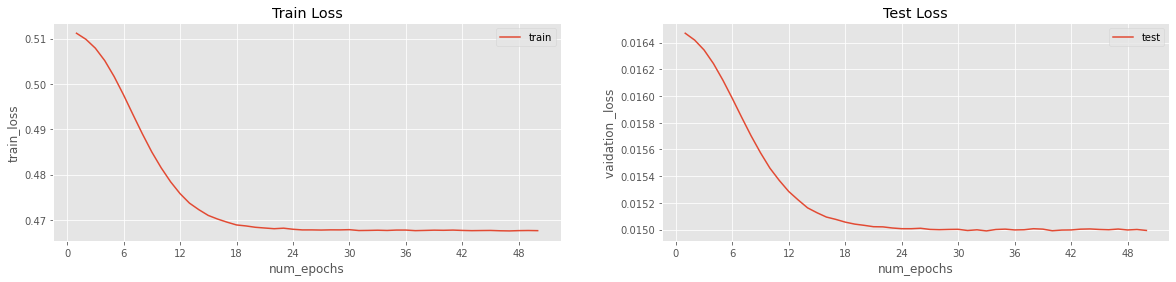

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(list(np.arange(50) + 1) , train_loss, label='train')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('train_loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')
ax = fig.add_subplot(1, 2, 2)
plt.title("Test Loss")
plt.plot(list(np.arange(50) + 1), test_loss, label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('vaidation _loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')